In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'depths.csv', 'sample_submission.csv', 'train.csv', 'train']


In [32]:
import os
import sys
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
from sklearn.utils import shuffle

%matplotlib inline
import keras
# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
t_start = time.time()

In [47]:
#Preparing data and masks
def data(dir_data):
    Images = []
        
    for image_file in os.listdir(dir_data): 
        image = cv2.imread(dir_data+r'/'+image_file) 
        #image = cv2.resize(image,(128,128)) 
        Images.append(image)
    
    return shuffle(Images,random_state=3) 

def mask(dir_mask):
    Masks = []
    GrayMasks=[]    
    for image_file in os.listdir(dir_mask): 
        mask = cv2.imread(dir_mask+r'/'+image_file, cv2.IMREAD_GRAYSCALE) 
        #mask = cv2.resize(mask,(128,128)) 
        Masks.append(mask)
    return shuffle(Masks,random_state=3)

In [48]:
Images = data('../input/train/images')
Images = np.array(Images)
print("Train Images : ",Images.shape)

Masks = mask('../input/train/masks')
Masks = np.array(Masks)
print(" Masks : ",Masks.shape)
print("Unique values in masks : ",np.unique(Masks)) 

Train Images :  (4000, 101, 101, 3)
 Masks :  (4000, 101, 101)
Unique values in masks :  [  0 255]


In [49]:
masks=(Masks>0)*1
print(" New Masks : ",masks.shape)
print("Unique values in new mask : ",np.unique(masks))    

 New Masks :  (4000, 101, 101)
Unique values in new mask :  [0 1]


In [50]:
def plot2x2Array(image, mask, true):
    #invoke matplotlib!
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[0].grid()
    axarr[1].grid()
    axarr[0].set_title('Image')
    if true==1:
        axarr[1].set_title('True Mask')
    if true==0:
        axarr[1].set_title('predicted Mask')

white(1) for salt and black(0) for background


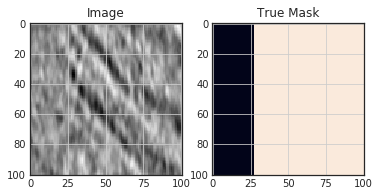

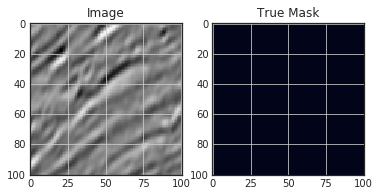

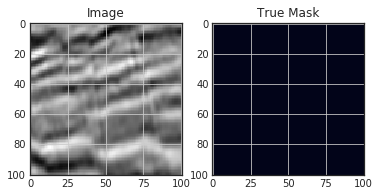

In [51]:
#Visualizing randomly 6 images with their masks
print("white(1) for salt and black(0) for background")
    
for i in range(3):
    n=np.random.randint(1,Images.shape[0])
    image = Images[n]
    mask = masks[n]
    plot2x2Array(image, mask, 1)    
 

In [52]:
#reshaping for ConvNet
masks=masks.reshape(masks.shape[0],masks.shape[1],masks.shape[2],1)
print("Train mask : ",masks.shape)

Train mask :  (4000, 101, 101, 1)


In [53]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

In [54]:
# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [55]:
def iou_coef(y_true, y_pred, smooth=1):
    """
    IoU = (|X &amp; Y|)/ (|X or Y|)
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    return (intersection + smooth) / ( union + smooth)

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

In [58]:
input_layer = Input((101, 101, 3))
output_layer = build_model(input_layer, 16,0.5)

model1 = Model(input_layer, output_layer)

c = optimizers.adam(lr = 0.01)
model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[iou_coef , "accuracy"])
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 101, 101, 3)  0                                            
__________________________________________________________________________________________________
conv2d_181 (Conv2D)             (None, 101, 101, 16) 448         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_91 (BatchNo (None, 101, 101, 16) 64          conv2d_181[0][0]                 
__________________________________________________________________________________________________
activation_93 (Activation)      (None, 101, 101, 16) 0           batch_normalization_91[0][0]     
__________________________________________________________________________________________________
conv2d_182

In [60]:
model1.fit(x=Images, y=masks, batch_size=32, epochs=25, verbose=1, validation_split=0.05)

Train on 3800 samples, validate on 200 samples
Epoch 1/25
3800/3800 [==============================] - 33s 9ms/step - loss: 0.4714 - iou_coef: 0.8059 - acc: 0.7824 - val_loss: 0.8414 - val_iou_coef: 0.8079 - val_acc: 0.7039
Epoch 2/25
3800/3800 [==============================] - 14s 4ms/step - loss: 0.3935 - iou_coef: 0.8464 - acc: 0.8355 - val_loss: 11.2868 - val_iou_coef: 0.6414 - val_acc: 0.2827
Epoch 3/25
3800/3800 [==============================] - 14s 4ms/step - loss: 0.3452 - iou_coef: 0.8656 - acc: 0.8642 - val_loss: 1.1049 - val_iou_coef: 0.8466 - val_acc: 0.7173
Epoch 4/25
3800/3800 [==============================] - 14s 4ms/step - loss: 0.3176 - iou_coef: 0.8779 - acc: 0.8773 - val_loss: 0.4272 - val_iou_coef: 0.9021 - val_acc: 0.8552
Epoch 5/25
3800/3800 [==============================] - 14s 4ms/step - loss: 0.2984 - iou_coef: 0.8851 - acc: 0.8838 - val_loss: 0.5371 - val_iou_coef: 0.8301 - val_acc: 0.7234
Epoch 6/25
3800/3800 [==============================] - 14s 4ms/ste

In [61]:
#Importing test images
Images_test = data('../input/test/images')
Images_test = np.array(Images_test)

testImages=Images_test[0:]
print("Test Images : ",testImages.shape)

Test Images :  (18000, 101, 101, 3)


In [63]:
## Save the Weights
model1.save_weights("UResNetW.h1")

## Dataset for prediction
result = model1.predict(testImages)

result = result > 0.5
result=result.reshape(testImages.shape[0],101,101)
#PREDICTS 18000 images IN 20secs!!!

Yellow(1) for salt and Purple(0) for background


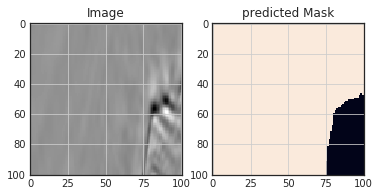

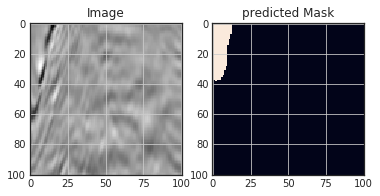

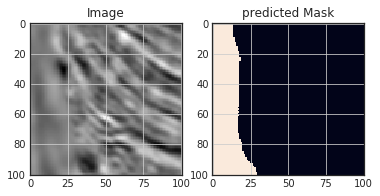

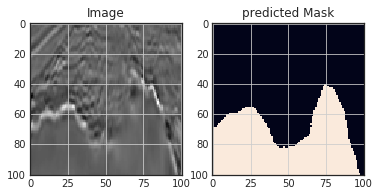

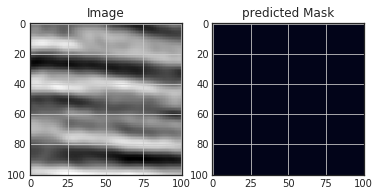

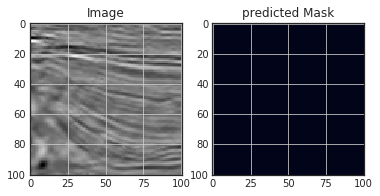

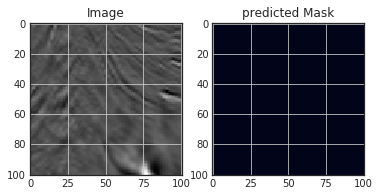

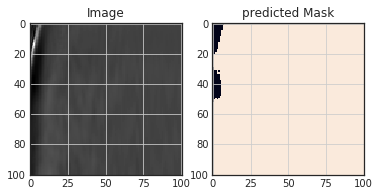

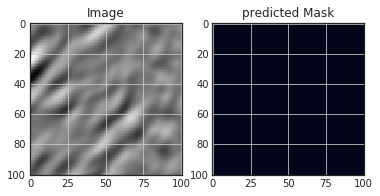

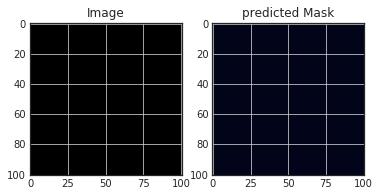

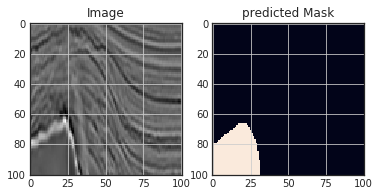

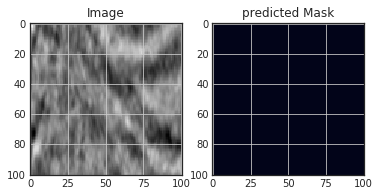

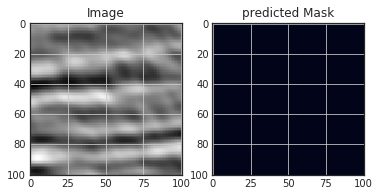

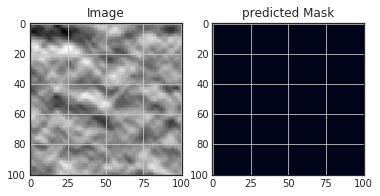

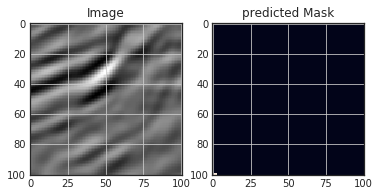

In [64]:
#Visualizing randomly 6 images with their masks
print("white(1) for salt and black(0) for background")
for i in range(15):
    n=np.random.randint(1,testImages.shape[0])
    plot2x2Array(testImages[n],result[n], 0)